In [ ]:
### 연구목표 및 Term project 주제
'''자영업자와 소상공인을 위한 대출과 금융지원 프로그램이 확대되고 있다고 하지만 실질적으로 도움을 받지 못하고 어려움을 겪는 
사업자들이 늘어나고 있다. 따라서 여러 업종의 사업장과 영업장에서 매출에 영향을 주는 요인이 무엇인지 알아보고, 신용카드사의 
매출액데이터, 거래일데이터, 업종데이터, 날씨데이터 등을 결합하여 상환 기간의 매출 예측 모델을 만들어 신용점수가 낮거나 사업 운영에 
어려움을 겪고 있는 업종들에게 우대금리와 같은 금융 기회를 제공할 수 있게 한다. 우리는 우선 대략 분기별 2~3달 값을 예측하여 상승 
추세가 있을 시 즉, 그 달의 값과의 차를 계산했을 때 양의 값을 가지게 되면 그 상승분에 5%(0.05)에 해당하는 금액을 대출가능한 금액으로 
지정한다. 금액은 100단위로 반올림된다. 예를 들어 1500만원 > 4500만원으로 3천만원의 상승분이 있을 시 3000만 * 5%를 하여 150만을 얻고 
반올림을 진행하여 200만원의 대출기회를 제공받을 수 있다. 이 기회를 이용해 현재 매출액이 떨어지는 하락 시즌이라 해도 미래 상승 
가능성이 있음을 예측으로 파악하여 대출기회를 제공해 소상공인들이 하락 시즌으로 재정적 부담이 있는 힘든 기간을 견딜 수 있는 기반을
만들어 준다.''''''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### tqdm을 통해 for문의 진행상황을 확인한다
### 한글이 깨지거나 음수 표현할때 그래프식

In [131]:
import matplotlib
from matplotlib import font_manager, rc
import platform
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False   

In [132]:
import seaborn as sns

In [931]:
ss = pd.read_csv("D:\\Desktop\\3학년 2학기\\데마\\우리 팀플\\Datamining_f\\Datamining_f.csv")

In [932]:
ss

,Unnamed: 0,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,average_temperature,precipitation(mm)
0,0,1,1931,b,2016-06-01,13:31,0,경기,한식음식점업,1071.428571,22.7,0.0
1,1,1,1932,h,2016-06-01,14:18,0,경기,한식음식점업,428.571429,22.7,0.0
2,2,1,1933,c,2016-06-01,15:07,0,경기,한식음식점업,1142.857143,22.7,0.0
3,3,1,1934,g,2016-06-01,15:12,0,경기,한식음식점업,1142.857143,22.7,0.0
4,4,1,1935,a,2016-06-01,16:06,0,경기,한식음식점업,1071.428571,22.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6554816,6556457,2136,4663855,d,2019-02-28,23:20,0,제주,주점,-4500.000000,10.4,0.1
6554817,6556458,2136,4663855,d,2019-02-28,23:24,0,제주,주점,4142.857143,10.4,0.1
6554818,6556459,2136,4663489,a,2019-02-28,23:24,0,제주,주점,4500.000000,10.4,0.1
6554819,6556460,2136,4663856,d,2019-02-28,23:27,0,제주,주점,571.428571,10.4,0.1


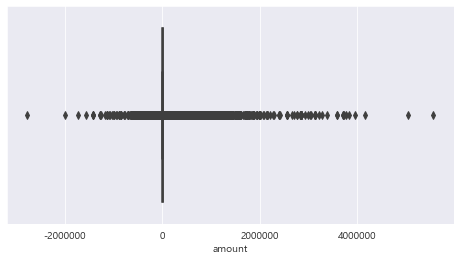

In [933]:
plt.figure(figsize=(8, 4))
sns.boxplot(ss['amount'])

### amount 매출액에 음수가 있는 것을 확인할 수 있다. > 환불금액인것을 알 수있다.
#### 음수는 log 정규화를 진행하면 값이 무한대가 나오기 때문에 제거할 필요가 있다.
#### 환불금액을 없애기 위해 환불금액을 제거하고 그와 금액이 같은 결제데이터중에서 가장 최근것을 지운다.

In [934]:
ss[ss['amount'] < 0].head()

,Unnamed: 0,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,average_temperature,precipitation(mm)
2631,2631,1,2992,b,2018-03-23,14:29,0,경기,한식음식점업,-1571.428571,5.3,0.0
2828,2828,1,2702,a,2018-05-17,16:17,0,경기,한식음식점업,-500.000000,21.6,64.8
2910,2910,1,2922,f,2018-06-14,15:43,0,경기,한식음식점업,-1071.428571,22.4,3.4
2911,2911,1,2922,f,2018-06-14,15:43,0,경기,한식음식점업,-1000.000000,22.4,3.4
3205,3205,1,3206,b,2018-09-12,15:19,0,경기,한식음식점업,-500.000000,22.5,0.0


In [935]:
ss['datetime'] = pd.to_datetime(ss.transacted_date + " " + ss.transacted_time, format = '%Y-%m-%d %H:%M:%S')
# 날짜를 합친다.

In [936]:
def refund_remove(df):
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] ##non_refund 스토어 데이터를 스토어별로 나눔
        divided_data2=refund[refund['store_id']==i] ##refund 스토어 데이터를 나눔 스토어별로 나눔
        
        for neg in divided_data2.to_records()[:]: ##환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] ## 환불 카드 아이디
            refund_datetime=neg['datetime'] ## 환불 시간
            refund_amount=abs(neg['amount']) ## 환불액 절대값을 씌움
                
            ##환불시간 이전의 데이터중 카드이이디와 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            #후보리스트가 있으면,카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['datetime']) ##가장 최근 시간을 구한다
                remove=divided_data[divided_data['datetime']==refund_datetime] ##가장 최근시간
                remove=remove[remove['card_id']==refund_id] ##환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] ##환불액
                divided_data=divided_data.drop(index=remove.index) #인덱스를 통해 제거
                    
        ##제거한데이터를 데이터프레임에 추가한다.
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data


In [937]:
ss = refund_remove(ss)

100%|█████████████████████████████████████████████| 1967/1967 [42:32<00:00,  1.30s/it]


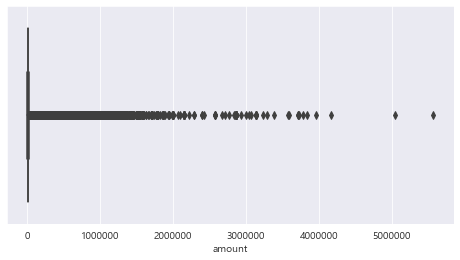

In [938]:
plt.figure(figsize=(8, 4))
sns.boxplot(ss['amount'])
## 0이하 음수값이 없어진 것을 확인할 수 있다.

In [939]:
ss.head(n=2)

,Unnamed: 0,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,average_temperature,precipitation(mm),datetime
0,0,1,1931,b,2016-06-01,13:31,0,경기,한식음식점업,1071.428571,22.7,0.0,2016-06-01 13:31:00
1,1,1,1932,h,2016-06-01,14:18,0,경기,한식음식점업,428.571429,22.7,0.0,2016-06-01 14:18:00


In [956]:
ss.to_csv('resource.csv')
## csv로 빼는방법

In [3]:
ss = pd.read_csv("D:\\Desktop\\3학년 2학기\\데마\\우리 팀플\\resource.csv")

### 일별 시/분까지 포함하는 데이터에서 월별 데이터로 down sampling

In [134]:
def month_resampling(df):
    new_data=pd.DataFrame() 
    df['year_month']=df['transacted_date'].str.slice(stop=7) # transacted_date에서 앞부터 7글자까지 잘라서 year_month 칼럼으로만듬
    year_month=df['year_month'].drop_duplicates()
    ## 중복데이터를 제거해주는 함수 drop_duplicates
    ## 저렇게 할시 각 달이 바뀌는 인덱스를 얻을 수 있다. 
    
    downsampling_data=df.groupby(['type_of_business', 'year_month']).amount.sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.type_of_business.unique()):
        store=downsampling_data[downsampling_data['type_of_business']==i]
        start_time=min(store['year_month'])
        store=store.merge(year_month,how='outer')
        store=store.sort_values(by=['year_month'], axis=0, ascending=True) ##데이터를 시간순으로 정렬
        
        store['amount']=store['amount'].fillna(2)   #매출이 발생하지 않는 월은 2로 채움
        store['type_of_business']=store['type_of_business'].fillna(i) #업종 결측치 채운다.
        store=store[store['year_month']>=start_time]  #매출 시작일 이후만 뽑는다.
        
        new_data=pd.concat([new_data,store],axis=0)
        
    return new_data

In [135]:
resam_ss = month_resampling(ss)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 87.42it/s]


In [136]:
resam_ss

,type_of_business,year_month,amount
0,한식음식점업,2016-06,3.058002e+08
1,한식음식점업,2016-07,3.386745e+08
2,한식음식점업,2016-08,3.328088e+08
3,한식음식점업,2016-09,3.287627e+08
4,한식음식점업,2016-10,3.697106e+08
...,...,...,...
24,컨설팅업,2018-10,8.281214e+06
25,컨설팅업,2018-11,7.345986e+06
26,컨설팅업,2018-12,7.403900e+06
27,컨설팅업,2019-01,4.991014e+06


### 시계열 데이터로 변환 후 예시 '재배업' 그래프화

In [137]:
def time_series(df,i):
    store=df[df['type_of_business']==i]
    index=pd.date_range(min(store['year_month']),'2019-03',freq="M") ##영업 시작일부터 2019년 2월까지 데이터가 존재 
    # 시계열 데이터로 변경 2016-06-30', '2016-07-29 이런형식
    ts=pd.Series(store['amount'].values,index=index)
    return ts

### 각각 업종별로 다 적용시킨다
- 시계열 데이터로 변환하며 값이 큰 순서대로 내림차순으로 정리되어 value 값을 통해 그 순서를 파악해 그 순서대로 각각의 시계열 데이터로 분리시킨다.

In [138]:
pd.unique(resam_ss['type_of_business'].values)

array(['한식음식점업', '미용업', '의류업', '주점', '패스트푸드', '외국음식', '간이음식', '식료품',
       '소매업', '학원', '여가시설', '작물판매', '세탁업', '수리업', '운동', '자동차', '재배업',
       '도매업', '숙박시설', '서비스업', '운송관련', '가정용품', '제조업', '의약품', '병원', '여행사업',
       '복제업', '공사업', '연구개발업', '예식장업', '컨설팅업'], dtype=object)

In [139]:
for i in tqdm(range(len(pd.unique(resam_ss['type_of_business'].values)))):
    globals()['buss{}'.format(i)] = time_series(resam_ss,pd.unique(resam_ss['type_of_business'].values)[i])

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 224.33it/s]


In [14]:
buss1.head()

2016-06-30    1.545237e+08
2016-07-31    1.651638e+08
2016-08-31    1.620084e+08
2016-09-30    1.546768e+08
2016-10-31    1.716689e+08
Freq: M, dtype: float64

In [140]:
resam_ss[resam_ss['type_of_business'] == '미용업'].head()

,type_of_business,year_month,amount
0,미용업,2016-06,1.545237e+08
1,미용업,2016-07,1.651638e+08
2,미용업,2016-08,1.620084e+08
3,미용업,2016-09,1.546768e+08
4,미용업,2016-10,1.716689e+08


### 몇개의 업종을 예시로 그래프로 나타내봄

In [141]:
resam_ss['type_of_business'].unique()[0:2]

array(['한식음식점업', '미용업'], dtype=object)

In [142]:
resam_ss[resam_ss['type_of_business']== '재배업'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
           dtype='int64')

In [143]:
resam_ss[resam_ss['type_of_business'] == '재배업'].amount.head()

0    1.201547e+07
1    1.551467e+07
2    2.239584e+07
3    2.217233e+07
4    1.747715e+07
Name: amount, dtype: float64

In [144]:
##업존 매출 시계열 그래프
def store_plot(data,start_id,end_id):
    plt.figure(figsize=(15, 6))
    for i in data['type_of_business'].unique()[start_id:end_id]:
        plt.plot(data[data['type_of_business']== i].index, data[data['type_of_business'] == i].amount, label='business_{}'.format(i))
    plt.legend()   

##업종 매출 분포
def store_displot(data,start_id,end_id):
    plt.figure(figsize=(15, 6))
    for i in data.type_of_business.unique()[start_id:end_id]:
        sns.distplot(data[data.type_of_business == i].amount)
    plt.grid()
    plt.show()

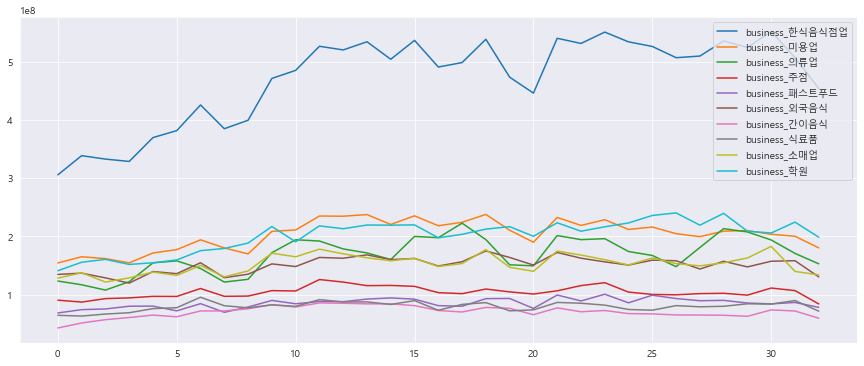

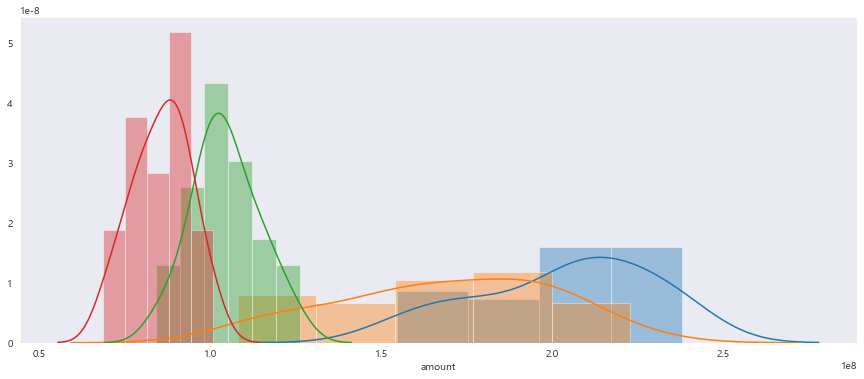

In [145]:
store_plot(resam_ss,0,10)
store_displot(resam_ss,1,5)

## 각 상점별 매출 특성과 분포가 다르므로 개별적인 시계열 모델링이 필요해 보입나다.
- 개별적 모델링이 필요하지만 사실 데이터 용량이 커질수록 수천~ 수만의 데이터를 하나하나 개별모델링 할 순 없다. >>> 그렇다면 보편적인 모델링 기준을 만들어 적용을 시킬까? 
  - 현재 시계열 분석을 처음 시작하는 만큼 그에 따른 기준 선정 및 방식에 관한 지식의 한계점이 존재한다. 또한 term project 특성상 중간발표, 제안서 제출 등 기한이 존재해 무작정 시도해 볼 수 없었다. >>> 한 업종을 예시로 시계열 분석에 대한 실습과 첫 적용에 의의를 두기로 한다.

In [199]:
a = [list(resam_ss[resam_ss['type_of_business'] == '미용업'].amount.values),list(resam_ss[resam_ss['type_of_business'] == '미용업'].amount.values)]

# HOLT WINTERS METHOD


## 하나의 예시를 통해 시계열 분해(STL) 및 Holt- Winters 지수평활법 분석
#### 의류업, 식료품

In [146]:
buss2[0:28].index

DatetimeIndex(['2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
               '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30'],
              dtype='datetime64[ns]', freq='M')

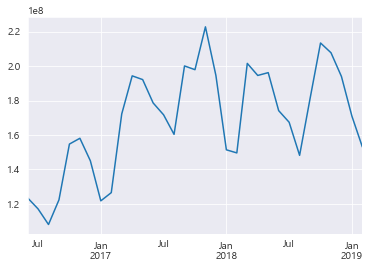

In [147]:
buss2.plot()
# train , test 셋 분해
buss2tr = buss2[0:28]
buss2te = buss2[28:]

In [148]:
buss2te

2018-10-31    2.134454e+08
2018-11-30    2.077768e+08
2018-12-31    1.939720e+08
2019-01-31    1.709335e+08
2019-02-28    1.530403e+08
Freq: M, dtype: float64

#### 그래프를 통해 대략적으로 파악해보면 반기 별로 계절성이 있다는 것을 알 수 있다.
#### 또한 가법, 승법모형 선택중 2017년 이전 제외 2018~2019년의 계절성의 분산이 일정한편이라 보여 가법모형 선택
- 가법모형을 선택하면서 seasonal, trend parameter가 multi가 아닌 add or additive로 선택될 것이다. 

In [ ]:
#Next, we estimate the model with and without robust weighting 
## robust 하게 outlier나 noise를 robust화 

In [149]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('darkgrid')

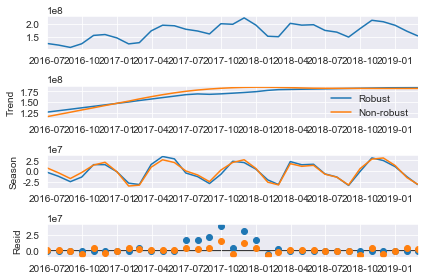

In [150]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)


stl = STL(buss2, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(buss2, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

### 추세와 계절성이 모두 존재. 계절성은 비율이 아닌 고정된 양만큼 다른 것으로 보아 가법 계절성으로 파악
### 또한 추세는 지속적으로 상승하는 모양이지만 뒤로갈수록 감쇠하는 형국 > damped 
- damped Parameter를 통해 2차함수 형태의 감쇠하는 상승추세에 대한 요인을 적용시켰지만 완벽하지 않았다. 또한 급격히 증가하는 2차함수, 급격히 감소하는 2차함수 등 여러가지 추세에 대한 해결책은 아직 한계점이 존재한다.

## 우선 추세와 계절성이 모두 있을때 사용할 수 있는 Holt-Winter 지수평활법을 사용한다.
- 차분을 하고 계절성이 있을시 계절성을 포함한 2차차분을 진행할 수 있지만 이후에 ARIMA, 회귀모형 등에 차분 데이터를 사용할 가능성이 있어 추세, 계절성이 모두 있을때도 사용가능한 지수 평활법인 홀트-윈터스 분석을 사용해본다.

In [151]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [159]:
model = ExponentialSmoothing(buss2tr, trend="add", seasonal="add", seasonal_periods=6, damped = True)

- 시각적으로 그래프를 파악하여 6,7개월 가량의 Seasonal 이 있지만 두가지를 모두 적용해 보았을때 6개월의 계절성이 더 유의미한 결과값이 나와 6개월을 기간으로 선택
  - 실제로는 window같은 method를 통해 시계열 기간을 축소해서 세세한 계절성을 파악할 필요가 있을 것 같다.

In [160]:
fit = model.fit()
pred = fit.forecast(5)

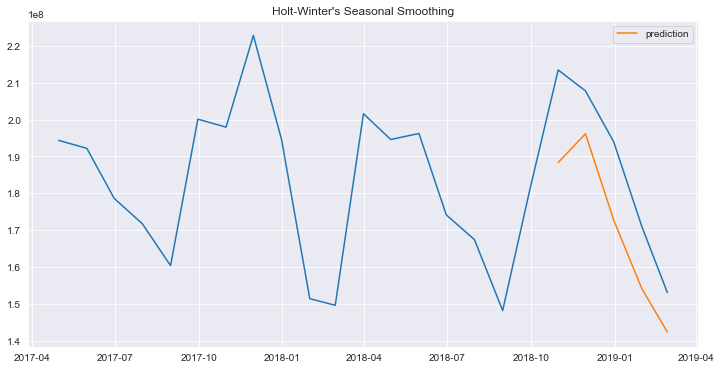

In [161]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(buss2.index[10:], buss2.values[10:]);
ax.plot(pred.index[0:], pred, label='prediction');
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

## valid랑 비교해서 accuracy를 측정해야한다.

In [155]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [156]:
mae = mean_absolute_error(y_pred = pred, y_true = buss2te)
print(mae)

17105387.741938036


In [157]:
rmse = np.sqrt(mean_squared_error(y_pred = pred, y_true = buss2te))
print(rmse)

17973718.347366612


## 전체 데이터를 적합해 최종모델로 2달 예측값 형성 

In [162]:
HOLTmodel = ExponentialSmoothing(buss2, trend="add", seasonal="add", seasonal_periods=6, damped = True)

In [164]:
HOLTfit = HOLTmodel.fit()
HOLTpred = HOLTfit.forecast(2)

In [165]:
HOLTpred

2019-03-31    1.950686e+08
2019-04-30    2.101526e+08
Freq: M, dtype: float64

# HOLT WINTERS의 BUSS2 최종모형 2달 예측값은 이와같다.

## 식료품으로 예제 사용

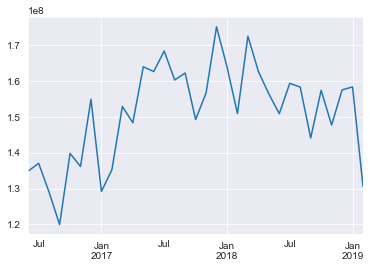

In [166]:
buss5.plot()
# train , test 셋 분해
buss5tr = buss5[0:28]
buss5te = buss5[28:]

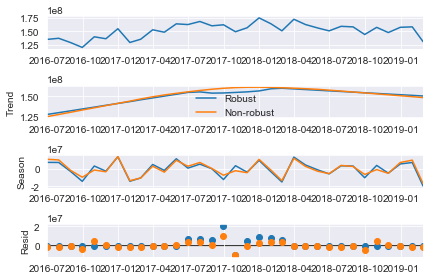

In [167]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)


stl = STL(buss5, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(buss5, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

### 추세는 존재하나 계절성이 뚜렷하지 않다. 10~ 2월사이에만 뚜렷한 계절성이 존재하는 것으로 보이나 그 외에는 애매하다.
- 그래서 윈터스 모델을 적용할때 계절성 값을 제거 or 제거하지 않은 버전을 모두 적용해 보았을때 계절성 parameter를 적용한 결과가 훨씬 의미있는 값이 나왔다.
- 여기서도 추세가 마지막에 감쇠하는 2차함수 형태를 가진다. 그러나 위의 첫 예시에 비해 급격한 감쇠추세를 가지는데 damped parameter를 통해 적용을 해도 급격한 감쇠는 반영이 잘 안되었다.

In [168]:
buss5tr.head()

2016-06-30    1.348692e+08
2016-07-31    1.370382e+08
2016-08-31    1.289520e+08
2016-09-30    1.199577e+08
2016-10-31    1.398104e+08
Freq: M, dtype: float64

In [180]:
model = ExponentialSmoothing(buss5tr,seasonal = "additive" , trend = "add", damped = True)

In [181]:
fit = model.fit()
pred = fit.forecast(5)

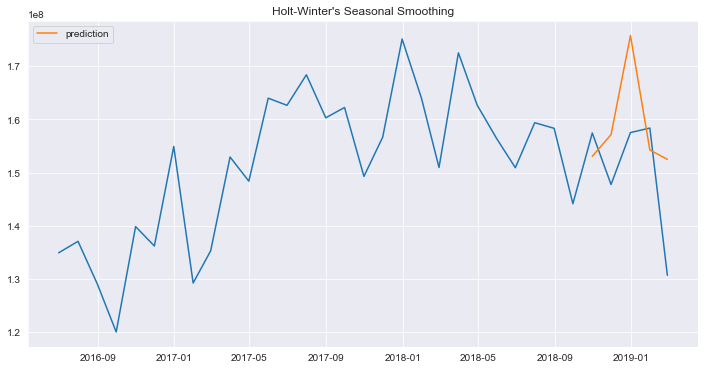

In [182]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(buss5.index[0:], buss5.values[0:]);
ax.plot(pred.index[0:], pred, label='prediction');
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

- damped를 통해 감쇠추세를 반영했음에도 불구하고, 급격한 감쇠를 다 반영하지 못해 이와 같은 안좋은 결과가 나왔다. 또한 계절성이 뚜렷하지 않은점, 그래서 생각해본점은 10~ 2월의 계절성이 있을때만 따로 분석을 해 반영시키고 나머지 계절성이 없는 기간을 따로 분석에 각각의 예측하는 방법을 써볼 수 있지 않을까 생각을 해보았다.

In [183]:
buss5te

2018-10-31    1.574434e+08
2018-11-30    1.477387e+08
2018-12-31    1.575243e+08
2019-01-31    1.583744e+08
2019-02-28    1.306451e+08
Freq: M, dtype: float64

In [184]:
mae = mean_absolute_error(y_pred = pred, y_true = buss5te)
print(mae)

11611858.6267297


In [185]:
rmse = np.sqrt(mean_squared_error(y_pred = pred, y_true = buss5te))
print(rmse)

13684759.015332283


In [187]:
HOLTmodel2 = ExponentialSmoothing(buss5tr,seasonal = "additive" , trend = "add", damped = True)

In [189]:
HOLTfit2 = HOLTmodel2.fit()
HOLTpred2 = HOLTfit2.forecast(2)

In [190]:
HOLTpred2

2018-10-31    1.530457e+08
2018-11-30    1.571417e+08
Freq: M, dtype: float64

# HOLT WINTERS의 BUSS5 최종모형 2달 예측값은 이와같다.

# -============================================================================

## ARIMA 분석

### ARIMA 같은 기법을 이용하기 위해 우선 시계열 데이터는 정상성을 만족해야한다. 
- 정상성 : (1) 평균이 일정 : 모든 시점에 대해 일정한 평균을 가진다.
- 평균이 일정하지 않은 시계열은 차분(difference)을 통해 정상화
- 차분은 현시점 자료에서 이전 시점 자료를 빼는 것
- (2) 분산도 시점에 의존하지 않음
- 분산이 일정하지 않은 시계열은 변환(transformation)을 통해 정상화
- (3) 공분산도 시차에만 의존할 뿐, 특정 시점에는 의존하지 않음

In [192]:
buss2tr = buss2[0:28]
buss2te = buss2[28:]

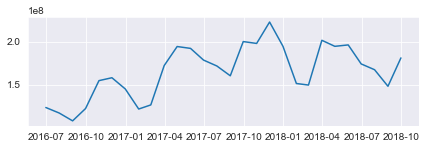

In [193]:
plt.figure(figsize=(7,2))
plt.plot(buss2tr)

### 위의 buss2 데이터를 보았을때 상승하는 추세가 있어 평균이 상승한다. > 비정상성 > 차분이 필요하다.
### 그렇지만 분산은 대략 일정한 것을 알 수 있다.

In [194]:
buss2di1 = buss2tr.diff()

In [195]:
buss2di1.head()

2016-06-30             NaN
2016-07-31   -6.412905e+06
2016-08-31   -9.090280e+06
2016-09-30    1.433283e+07
2016-10-31    3.238989e+07
Freq: M, dtype: float64

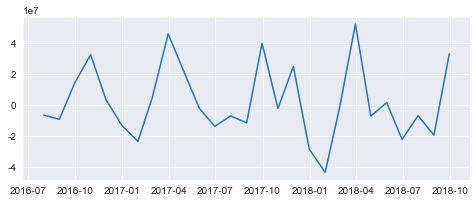

In [196]:
plt.figure(figsize=(8,3))
plt.plot(buss2di1)

- KPSS 검정을 통한 정상성 검정시 정상성이 만족한다고 나왔다. 하지만 원데이터에 적용시켜도 정상성이 만족한다고 나와 의문이 있다.
  - 육안으로도 추세가 보이는데 정상성이 왜 만족하는지 이해하는데 한계점 존재

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


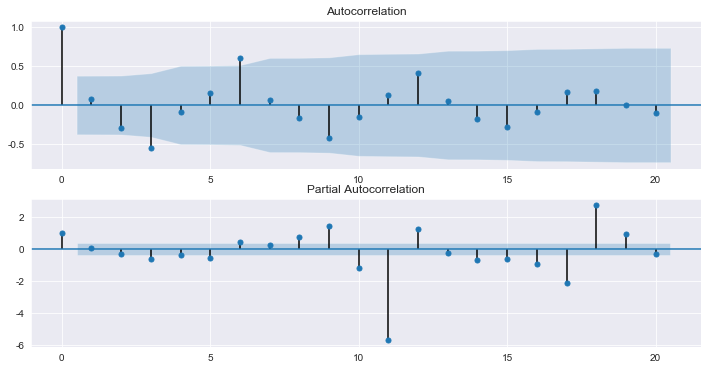

In [197]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(buss2di1.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(buss2di1.dropna(), ax=ax[1], lags=20)

### acf,pacf에서 특별한 관계가 나오지 않아 ARIMA(p,q)를 늘려가며 AIC를 통해 적절한 모형을 찾음
### ACF를 보면 3개월 가량의 계절성이 보이는 것으로 보이나 계절성 차분이 들어간 2차 차분을 할 만큼 유의한 값들이 나오지 않았다. PACF도 lag 10 이후에도 비정상적인 값들이 나와 무시하고 지나갔다. 그리하여 p, q를 max = 2로 두고 하나씩 적용시켜보며 AIC값 비교 >> Auto arima 적용해볼 수 있으나 실제 적용해 보고 싶어 이런 선택을 함
- (1,0,1) 모형은 P Value가 유의하지 않게나온다.
- (0,0,1) 모형은 P Value가 유의하지 않게 나온다. p value > 0.05
- (1,0,1) 모형은 P Value가 유의하고 AIC는 996가 나온다.
- (2,0,1) 모형은 P Value가 유의하고 AIC는 992이 나온다.
- (1,0,2) 모형은 P Value가 유의하지 않음
### AIC가 가장 낮은 (2,0,1) 모형을 사용하여 예측값을 뽑아본다. 원모형 buss2tr을 넣으니 1차차분하는 d =1 값넣어서 (2,1,1) 모형 사용

In [199]:
from statsmodels.tsa.arima_model import ARIMA

In [200]:
model1 = ARIMA(buss2tr.dropna(), order=(2,1,1))
model_fit = model1.fit(trend='nc',full_output= 5, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   27
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -492.357
Method:                       css-mle   S.D. of innovations       19832428.210
Date:                Wed, 09 Dec 2020   AIC                            992.715
Time:                        16:02:29   BIC                            997.898
Sample:                    07-31-2016   HQIC                           994.256
                         - 09-30-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.5921      0.207      2.862      0.004       0.187       0.998
ar.L2.D.y     -0.4713      0.171     -2.750      0.006      -0.807      -0.135
ma.L1.D.y     -0.6131      0.164     -3.731      0.0

In [201]:
ss = model_fit.forecast(steps = 5)
print(model_fit.forecast(steps = 5))

(array([1.94678421e+08, 1.87163273e+08, 1.76329692e+08, 1.73457669e+08,
       1.76863462e+08]), array([19832428.2099987 , 27753900.70171754, 29440190.05322823,
       29757882.8913701 , 30282450.37499618]), array([[1.55807576e+08, 2.33549266e+08],
       [1.32766627e+08, 2.41559919e+08],
       [1.18627980e+08, 2.34031405e+08],
       [1.15133290e+08, 2.31782048e+08],
       [1.17510949e+08, 2.36215974e+08]]))


In [202]:
buss2te

2018-10-31    2.134454e+08
2018-11-30    2.077768e+08
2018-12-31    1.939720e+08
2019-01-31    1.709335e+08
2019-02-28    1.530403e+08
Freq: M, dtype: float64

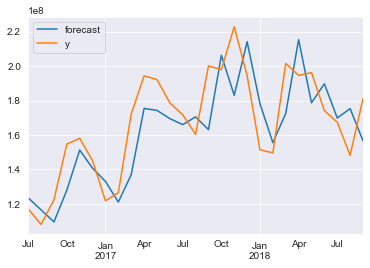

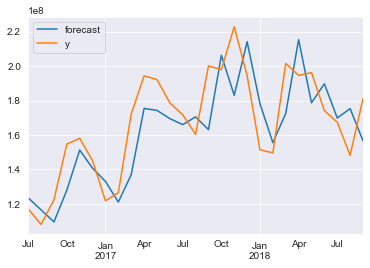

In [203]:

model_fit.plot_predict()

In [204]:
mae = mean_absolute_error(y_pred = ss[0], y_true = buss2te)
print(mae)
rmse = np.sqrt(mean_squared_error(y_pred = ss[0] , y_true = buss2te))
print(rmse)

16674046.094402105
18233417.548936


- 홀트-윈터스와 비슷한 결과 값이 나온다. 아마 auto_arima를 통한 최적의 p,q값과 좀더 적절한 parameter 값을 적용해나가면 더 좋은 결과값을 얻을 것이라 예상

# 최종모형 구축

In [205]:
buss2diresult = buss2.diff()

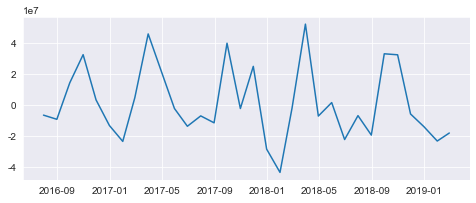

In [206]:
plt.figure(figsize=(8,3))
plt.plot(buss2diresult)

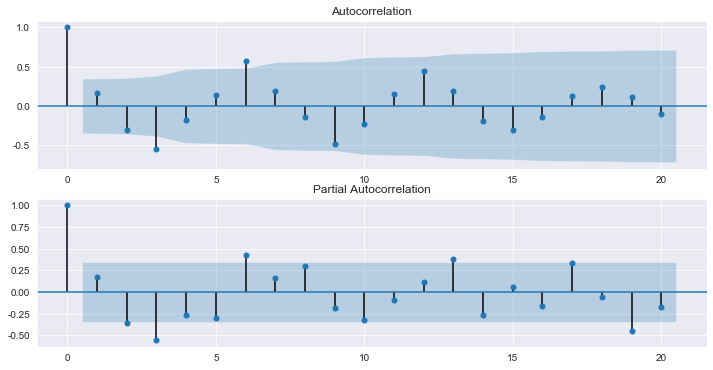

In [207]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(buss2diresult.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(buss2diresult.dropna(), ax=ax[1], lags=20)

#### (0,1,1) AIC = 1177
#### (1,1,0) AIC = 1178
#### (2,1,1) AIC = 1176
#### (0,1,2) AIC = 1177
#### (1,1,1) AIC = 1179
#### (2,1,1) AIC = 1171
#### (1,1,2) AIC = 1177
### (2,1,1) 선택

In [278]:
model1 = ARIMA(buss2.dropna(), order=(2,1,1))
model_fit = model1.fit(trend='nc',full_output= 5, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   32
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -581.961
Method:                       css-mle   S.D. of innovations       18874812.383
Date:                Wed, 09 Dec 2020   AIC                           1171.921
Time:                        18:19:13   BIC                           1177.784
Sample:                    07-31-2016   HQIC                          1173.865
                         - 02-28-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.6846      0.177      3.860      0.000       0.337       1.032
ar.L2.D.y     -0.5246      0.148     -3.555      0.000      -0.814      -0.235
ma.L1.D.y     -0.6424      0.145     -4.419      0.0

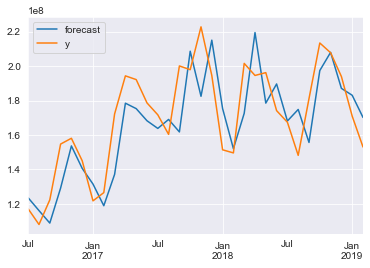

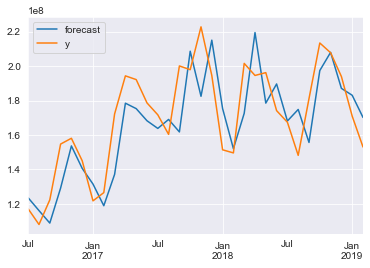

In [279]:
model_fit.plot_predict()

In [282]:
ss = model_fit.forecast(steps = 2)
print(model_fit.forecast(steps = 2)[0])

[1.63898977e+08 1.80719405e+08]


# ---------------------------------------------------------------------------

## 식료품 예제를 이용해본다 

In [1033]:
buss5tr = buss5[0:28]
buss5te = buss5[28:]

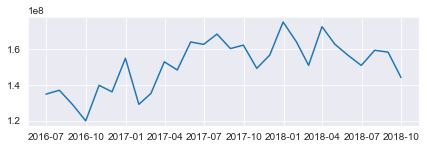

In [1034]:
plt.figure(figsize=(7,2))
plt.plot(buss5tr)

In [726]:
## 추세가 확연하지 않다. 차분을 해야할지 애매하다. 
## 단위근 검정을 해서 차분이 필요한지 않한지 검정이 필요하다.

In [1036]:
from statsmodels.tsa.stattools import kpss
def kpss_test(data):
    statistic, p_value, n_lags, critical_values = kpss(data, regression='c', lags='auto')
    print(f'KPSS test results:')
    print(f'\t\t Test Statistic:  {statistic}')
    print(f'\t\t p-value: {p_value}')


    print("-----------------result----------------------")
    if(p_value <= 0.05):
        print(p_value," <= 0.05 이므로 유의수준 5%하에서 귀무가설을 기각할만한 충분한 근거가 되므로 정상성을 만족한다")
    else:
        print(p_value," > 0.05 이므로 유의수준 5%하에서 귀무가설을 기각하지못한다. 자료에 단위근이 존재한다")

In [1037]:
buss5di1 = buss5tr.diff()

In [1038]:
kpss_test(buss5tr)

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'lags' keyword is deprecated, use 'nlags' instead
  This is separate from the ipykernel package so we can avoid doing imports until


KPSS test results:
		 Test Statistic:  0.5217954373079451
		 p-value: 0.03675778439010246
-----------------result----------------------
0.03675778439010246  <= 0.05 이므로 유의수준 5%하에서 귀무가설을 기각할만한 충분한 근거가 되므로 정상성을 만족한다


In [1039]:
kpss_test(buss5di1.dropna())

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'lags' keyword is deprecated, use 'nlags' instead
  This is separate from the ipykernel package so we can avoid doing imports until


KPSS test results:
		 Test Statistic:  0.5000000000000002
		 p-value: 0.041666666666666616
-----------------result----------------------
0.041666666666666616  <= 0.05 이므로 유의수준 5%하에서 귀무가설을 기각할만한 충분한 근거가 되므로 정상성을 만족한다


In [ ]:
## 둘다 유의한 결과가 나오지만 눈으로 보기에 추세가 있고
## 차분을 진행하는것이 단위근 검정에서 t 통계량이 더 좋다고 나온다.

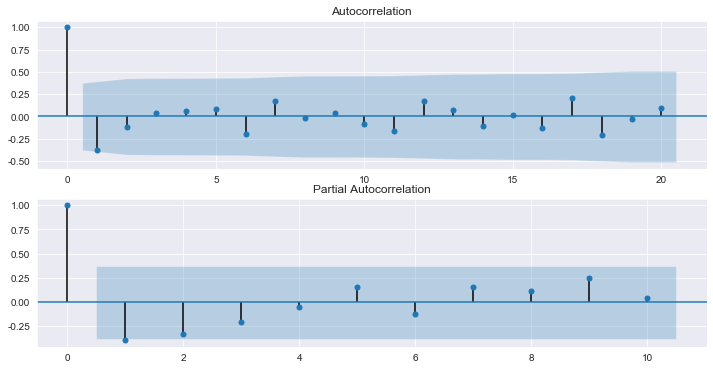

In [1040]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(buss5di1.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(buss5di1.dropna(), ax=ax[1], lags=10)

### acf,pacf에서 AR(1) 혹은 MA(1) 모형을 사용하는 것이 좋다고 나옴. 그래도 혹시모르니 max 2로 두고 AIC를 두고 비교
- (1,0,0) 모형은 P Value가 유의하고 AIC는 957이 나온다..
- (0,0,1) 모형은 P Value가 유의하고 AIC는 955가 나온다.
- (1,0,1) 모형은 P Value가 유의하지 않게나온다.
- (2,0,1) 모형은 P Value가 유의하지 않게나온다.
- (1,0,2) 모형은 P Value가 유의하고 AIC는 957이 나온다.
### AIC가 가장 낮은 (0,0,1) 모형을 사용하여 예측값을 뽑아본다. 원모형 buss2tr을 넣으니 1차차분하는 d =1 값넣어서 (0,1,1) 모형 사용 

In [1063]:
model1 = ARIMA(buss5tr.dropna(), order=(0,1,1))
model_fit = model1.fit(trend='nc',full_output= 5, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   27
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -475.515
Method:                       css-mle   S.D. of innovations       10701606.406
Date:                Wed, 02 Dec 2020   AIC                            955.029
Time:                        16:21:31   BIC                            957.621
Sample:                    07-31-2016   HQIC                           955.800
                         - 09-30-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y     -0.5546      0.148     -3.748      0.000      -0.845      -0.265
                                    Roots                                    
                  Real          Imaginary           M

In [1064]:
ss = model_fit.forecast(steps = 5)
print(model_fit.forecast(steps = 5))

(array([1.51785645e+08, 1.51785645e+08, 1.51785645e+08, 1.51785645e+08,
       1.51785645e+08]), array([10701606.40619306, 11714975.31318788, 12647407.38270617,
       13515664.26113269, 14331414.70110988]), array([[1.30810882e+08, 1.72760408e+08],
       [1.28824715e+08, 1.74746574e+08],
       [1.26997182e+08, 1.76574108e+08],
       [1.25295430e+08, 1.78275860e+08],
       [1.23696588e+08, 1.79874701e+08]]))


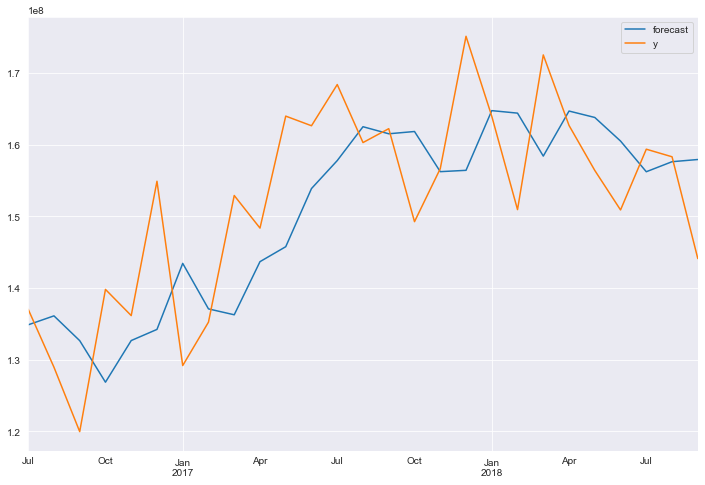

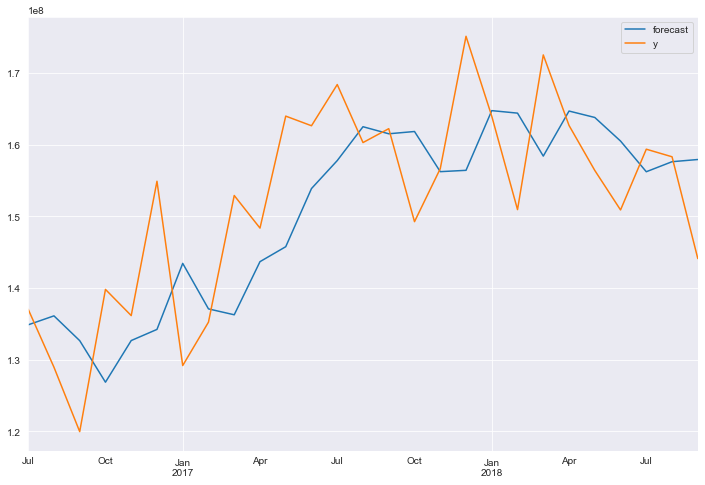

In [1065]:
model_fit.plot_predict()

In [1066]:
mae = mean_absolute_error(y_pred = ss[0], y_true = buss5te)
print(mae)
rmse = np.sqrt(mean_squared_error(y_pred = ss[0] , y_true = buss5te))
print(rmse)

8634552.286828097
10692580.156832982


# -=======================================================

# -=========================================================

# -------------===================================================

# 시계열 회귀분석 방법을 이용한 회귀모형을 적합

In [224]:
buss2.head()

2016-06-30    1.235076e+08
2016-07-31    1.170947e+08
2016-08-31    1.080044e+08
2016-09-30    1.223373e+08
2016-10-31    1.547272e+08
Freq: M, dtype: float64

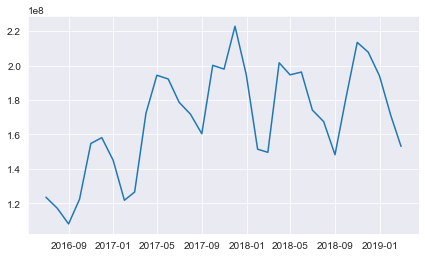

In [225]:
plt.figure(figsize = (7,4))
plt.plot(buss2)

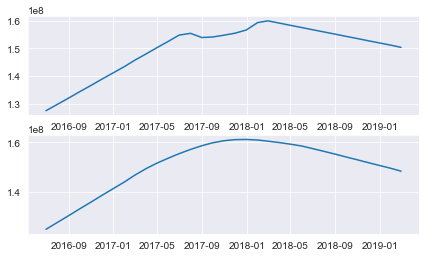

In [226]:
plt.figure(figsize = (7,4))
plt.subplot(2,1,1)
plt.plot(res_robust.trend)
plt.subplot(2,1,2)
plt.plot(res_non_robust.trend)

- 평균적으로 증가하는 추세가 있음 
- 회귀모형 적합에 추세가 있을시 독립변수로 t, t^2 등의 변수를 추가한다. 
- 1차 선형식으로 추세가 있을시 t만 넣어서 만들면 되지만 위의 그래프처럼 2차 함수의 그래프 형태로 나올시 t2을 넣어야한다.
- 우상향 볼록 2차함수 형태를 가지니 예를들어
### R = B0 + B1t + B2(t^2) 형태가 된다.

In [227]:
month1 = np.array([6,7,8,9,10,11,12])
month2 = np.arange(1,13) 
month3 = np.array([1,2])

In [228]:
month = np.concatenate((month1,month2,month2,month3), axis=None)

In [229]:
# 계절을 반영하는 가변수(dummy variable)을 모형에 독립변수로 추가하기 위해 계절성 분석
import statsmodels.api as sm #회귀분석에 사용할 모듈

# buss2 는 16년 6월부터 시작하고 2019년 2월까지 존재 
# 그때까지의 월을 나타내는 attribute를 만들어 새로운 데이터프레임 생성

newda = pd.DataFrame(buss2, columns = ['amount'])
newda['month'] = month
newda['month'] = newda['month'].astype('int')
newda.head(3)

,amount,month
2016-06-30,1.235076e+08,6
2016-07-31,1.170947e+08,7
2016-08-31,1.080044e+08,8


In [230]:
newnewdadummy = pd.get_dummies(newda['month'], drop_first = True)
newnewdadummy.head()

,2,3,4,5,6,7,8,9,10,11,12
2016-06-30,0,0,0,0,1,0,0,0,0,0,0
2016-07-31,0,0,0,0,0,1,0,0,0,0,0
2016-08-31,0,0,0,0,0,0,1,0,0,0,0
2016-09-30,0,0,0,0,0,0,0,1,0,0,0
2016-10-31,0,0,0,0,0,0,0,0,1,0,0


In [231]:
## time, time2 attribute 까지 추가해서 새롭게 하나 다시 만든다.
newnewdadummy1 = newnewdadummy.copy()
newnewdadummy1['time'] = np.arange(1,34)
newnewdadummy1['time1'] = (newnewdadummy1['time'])**2
newnewdadummy1.head()

,2,3,4,5,6,7,8,9,10,11,12,time,time1
2016-06-30,0,0,0,0,1,0,0,0,0,0,0,1,1
2016-07-31,0,0,0,0,0,1,0,0,0,0,0,2,4
2016-08-31,0,0,0,0,0,0,1,0,0,0,0,3,9
2016-09-30,0,0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,0,0,0,0,0,0,0,0,1,0,0,5,25


In [232]:
newnewdadummy1 = sm.add_constant(newnewdadummy1,has_constant = 'add')
newnewdadummy1.head()

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\WIN10HOME\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\WIN10HOME\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\WIN10HOME\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\WIN10HOME\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning

,const,2,3,4,5,6,7,8,9,10,11,12,time,time1
2016-06-30,1.0,0,0,0,0,1,0,0,0,0,0,0,1,1
2016-07-31,1.0,0,0,0,0,0,1,0,0,0,0,0,2,4
2016-08-31,1.0,0,0,0,0,0,0,1,0,0,0,0,3,9
2016-09-30,1.0,0,0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,1.0,0,0,0,0,0,0,0,0,1,0,0,5,25


In [235]:
# sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'][0:28],newnewdadummy1[0:28])
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()

In [236]:
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     21.71
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           4.92e-07
Time:                        16:21:10   Log-Likelihood:                -479.33
No. Observations:                  28   AIC:                             986.7
Df Residuals:                      14   BIC:                             1005.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.427e+07   9.43e+06      6.812      0.000     4.4e+07    8.45e+07
2          -7.501e+05   9.31e+06     -0.081      0.937   -2.07e+07    1.92e+07
3           4.634e+07   9.32e+06      4.972      0.000    2.63e+07    6.63e+07
4            5.26e+07   9.34e+06      5.635      0.000    3.26e+07    7.26e+07
5           5.152e+07   9.36e+06      5.503      0.000    3.14e+07    7.16e+07
6           3.903e+07   8.76e+06      4.454      0.001    2.02e+07    5.78e+07
7           2.964e+07   8.74e+06      3.390      0.004    1.09e+07    4.84e+07
8           1.418e+07   8.75e+06      1.621      0.127   -4.58e+06    3.29e+07
9           4.143e+07   8.77e+06      4.723      0.000    2.26e+07    6.02e+07
10          4.929e+07   9.34e+06      5.276      0.000    2.93e+07    6.93e+07
11          5.977e+07   9.32e+06      6.411      0.000    3.98e+07    7.98e+07
12          3.593e+07   9.31e+06      3.858      0.002     1.6e+07    5.59e+07
time         9.07e+06   1.02e+06      8.867      0.000    6.88e+06    1.13e+07
time1      -2.357e+05   3.44e+04     -6.848      0.000    -3.1e+05   -1.62e+05
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.292
Skew:                          -0.231   Prob(JB):                        0.864
Kurtosis:                       2.809   Cond. No.                     5.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
newnewdadummy2 = newnewdadummy1.drop(2,axis = 1)
newnewdadummy2.head()

,const,3,4,5,6,7,8,9,10,11,12,time,time1
2016-06-30,1.0,0,0,0,1,0,0,0,0,0,0,1,1
2016-07-31,1.0,0,0,0,0,1,0,0,0,0,0,2,4
2016-08-31,1.0,0,0,0,0,0,1,0,0,0,0,3,9
2016-09-30,1.0,0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,1.0,0,0,0,0,0,0,0,1,0,0,5,25


In [239]:
# sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'][0:28],newnewdadummy2[0:28])
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     25.19
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           9.43e-08
Time:                        16:21:27   Log-Likelihood:                -479.33
No. Observations:                  28   AIC:                             984.7
Df Residuals:                      15   BIC:                             1002.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.39e+07   7.97e+06      8.016      0.000    4.69e+07    8.09e+07
3           4.671e+07    7.8e+06      5.991      0.000    3.01e+07    6.33e+07
4           5.298e+07   7.81e+06      6.782      0.000    3.63e+07    6.96e+07
5           5.189e+07   7.84e+06      6.622      0.000    3.52e+07    6.86e+07
6           3.941e+07   7.18e+06      5.488      0.000    2.41e+07    5.47e+07
7           3.002e+07   7.15e+06      4.195      0.001    1.48e+07    4.53e+07
8           1.456e+07   7.15e+06      2.035      0.060   -6.93e+05    2.98e+07
9           4.181e+07   7.18e+06      5.822      0.000    2.65e+07    5.71e+07
10          4.966e+07   7.84e+06      6.337      0.000     3.3e+07    6.64e+07
11          6.014e+07   7.81e+06      7.699      0.000    4.35e+07    7.68e+07
12           3.63e+07    7.8e+06      4.656      0.000    1.97e+07    5.29e+07
time         9.07e+06   9.88e+05      9.176      0.000    6.96e+06    1.12e+07
time1      -2.357e+05   3.33e+04     -7.087      0.000   -3.07e+05   -1.65e+05
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.293
Skew:                          -0.232   Prob(JB):                        0.864
Kurtosis:                       2.808   Cond. No.                     3.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
newnewdadummy3 = newnewdadummy2.drop(8,axis = 1)
newnewdadummy3.head()

,const,3,4,5,6,7,9,10,11,12,time,time1
2016-06-30,1.0,0,0,0,1,0,0,0,0,0,1,1
2016-07-31,1.0,0,0,0,0,1,0,0,0,0,2,4
2016-08-31,1.0,0,0,0,0,0,0,0,0,0,3,9
2016-09-30,1.0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,1.0,0,0,0,0,0,0,1,0,0,5,25


In [241]:
# sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'][0:28],newnewdadummy3[0:28])
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     22.66
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.11e-07
Time:                        16:21:36   Log-Likelihood:                -482.75
No. Observations:                  28   AIC:                             989.5
Df Residuals:                      16   BIC:                             1005.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.284e+07   7.28e+06     10.012      0.000    5.74e+07    8.83e+07
3           4.091e+07   7.94e+06      5.154      0.000    2.41e+07    5.77e+07
4            4.71e+07   7.94e+06      5.934      0.000    3.03e+07    6.39e+07
5           4.589e+07   7.94e+06      5.779      0.000    2.91e+07    6.27e+07
6            3.25e+07   6.92e+06      4.697      0.000    1.78e+07    4.72e+07
7           2.314e+07    6.9e+06      3.355      0.004    8.52e+06    3.78e+07
9           3.487e+07   6.91e+06      5.045      0.000    2.02e+07    4.95e+07
10          4.371e+07   7.95e+06      5.497      0.000    2.69e+07    6.06e+07
11          5.429e+07   7.94e+06      6.834      0.000    3.75e+07    7.11e+07
12          3.052e+07   7.94e+06      3.843      0.001    1.37e+07    4.74e+07
time        8.529e+06   1.04e+06      8.191      0.000    6.32e+06    1.07e+07
time1      -2.168e+05   3.49e+04     -6.207      0.000   -2.91e+05   -1.43e+05
==============================================================================
Omnibus:                        0.989   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.610   Jarque-Bera (JB):                0.812
Skew:                          -0.074   Prob(JB):                        0.666
Kurtosis:                       2.179   Cond. No.                     2.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

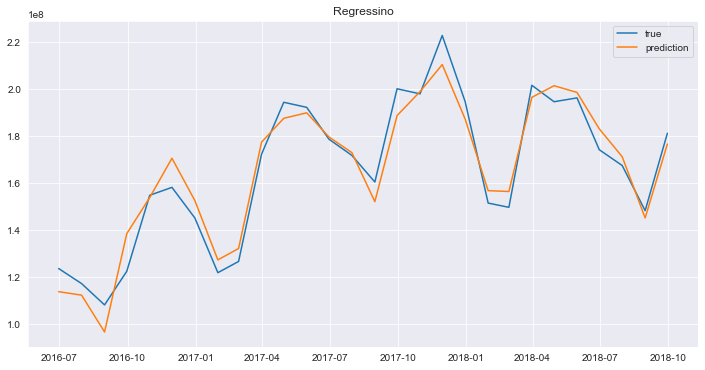

In [242]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(buss2.index[0:28], buss2.values[0:28], label = 'true');
ax.plot(buss2.index[0:28], fitted_model1.predict(), label='prediction');
ax.legend();
ax.set_title("Regressino");

In [243]:
fitted_model1.predict()

array([1.13651571e+08, 1.12169941e+08, 9.64793909e+07, 1.38364181e+08,
       1.53775720e+08, 1.70502723e+08, 1.52443643e+08, 1.27199547e+08,
       1.32042601e+08, 1.77363563e+08, 1.87522789e+08, 1.89860570e+08,
       1.79574083e+08, 1.72888545e+08, 1.51994086e+08, 1.88674968e+08,
       1.98882598e+08, 2.10405692e+08, 1.87142704e+08, 1.56694699e+08,
       1.56333845e+08, 1.96450899e+08, 2.01406217e+08, 1.98540088e+08,
       1.83049693e+08, 1.71160246e+08, 1.45061879e+08, 1.76538853e+08])

In [115]:
buss2[28:]

2018-10-31    2.134454e+08
2018-11-30    2.077768e+08
2018-12-31    1.939720e+08
2019-01-31    1.709335e+08
2019-02-28    1.530403e+08
Freq: M, dtype: float64

In [244]:
result = [181562200,187880001,159414200,124415200,118201800] #예측값을 구해본다

In [245]:
result1 = pd.Series(result)

In [246]:
result1

0    181562200
1    187880001
2    159414200
3    124415200
4    118201800
dtype: int64

In [ ]:
mae = mean_absolute_error(y_pred = result1, y_true = buss2[28:])
print(mae)
rmse = np.sqrt(mean_squared_error(y_pred = result1 , y_true = buss2[28:]))
print(rmse)

### 그래프를 보면 가장 True 값을 잘 따라가 좋은 예측값이 나올것 같았지만 MAE, RMSE 값을 보면 3천만으로 위의 ARIMA, 홀트 윈터스 기법에 비해 가장 좋지 않은 결과가 나온다.
- 아마 시계열 회귀모형 특성상 시간 가변수로 t^2을 넣게 되어 더 먼 예측치를 예측할 수록 변동이 커진다. 그로인해 예측치를 멀리 예측할 수록 유의미하지 않은 값이 나온다. but 그래프를 보면 가장 비슷한 결과값을 가지니 가까운 예측치를 구할땐 가장 적합할 가능성이 존재.

# 최종모형 구하기

In [251]:
# sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'],newnewdadummy1)
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     14.54
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           3.34e-07
Time:                        16:23:47   Log-Likelihood:                -575.89
No. Observations:                  33   AIC:                             1180.
Df Residuals:                      19   BIC:                             1201.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.596e+07   9.75e+06      8.815      0.000    6.56e+07    1.06e+08
2          -5.998e+06   9.88e+06     -0.607      0.551   -2.67e+07    1.47e+07
3           3.784e+07   1.12e+07      3.368      0.003    1.43e+07    6.14e+07
4           4.335e+07   1.12e+07      3.863      0.001    1.99e+07    6.68e+07
5           4.129e+07   1.12e+07      3.685      0.002    1.78e+07    6.47e+07
6           2.509e+07      1e+07      2.507      0.021    4.15e+06     4.6e+07
7           1.558e+07   9.97e+06      1.563      0.135   -5.29e+06    3.64e+07
8          -2.096e+05   9.94e+06     -0.021      0.983    -2.1e+07    2.06e+07
9           2.649e+07   9.92e+06      2.671      0.015    5.73e+06    4.73e+07
10          4.529e+07    9.9e+06      4.574      0.000    2.46e+07     6.6e+07
11          5.102e+07   9.89e+06      5.160      0.000    3.03e+07    7.17e+07
12          3.111e+07   9.88e+06      3.149      0.005    1.04e+07    5.18e+07
time        6.287e+06   9.61e+05      6.544      0.000    4.28e+06     8.3e+06
time1      -1.284e+05   2.74e+04     -4.677      0.000   -1.86e+05   -7.09e+04
==============================================================================
Omnibus:                        2.736   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                1.447
Skew:                           0.162   Prob(JB):                        0.485
Kurtosis:                       2.027   Cond. No.                     6.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [252]:
newnewdadummy2 = newnewdadummy1.drop(8,axis = 1)
newnewdadummy2.head()

,const,2,3,4,5,6,7,9,10,11,12,time,time1
2016-06-30,1.0,0,0,0,0,1,0,0,0,0,0,1,1
2016-07-31,1.0,0,0,0,0,0,1,0,0,0,0,2,4
2016-08-31,1.0,0,0,0,0,0,0,0,0,0,0,3,9
2016-09-30,1.0,0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,1.0,0,0,0,0,0,0,0,1,0,0,5,25


In [255]:
# sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'],newnewdadummy2)
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     16.58
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           7.87e-08
Time:                        16:25:21   Log-Likelihood:                -575.89
No. Observations:                  33   AIC:                             1178.
Df Residuals:                      20   BIC:                             1197.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.585e+07   7.94e+06     10.810      0.000    6.93e+07    1.02e+08
2          -5.895e+06   8.37e+06     -0.704      0.490   -2.34e+07    1.16e+07
3           3.795e+07   9.79e+06      3.877      0.001    1.75e+07    5.84e+07
4           4.345e+07   9.79e+06      4.439      0.000     2.3e+07    6.39e+07
5           4.139e+07   9.78e+06      4.231      0.000     2.1e+07    6.18e+07
6           2.519e+07    8.4e+06      3.000      0.007    7.67e+06    4.27e+07
7           1.569e+07   8.37e+06      1.874      0.076   -1.78e+06    3.31e+07
9            2.66e+07   8.34e+06      3.188      0.005     9.2e+06     4.4e+07
10          4.539e+07   8.34e+06      5.444      0.000     2.8e+07    6.28e+07
11          5.112e+07   8.34e+06      6.132      0.000    3.37e+07    6.85e+07
12          3.121e+07   8.34e+06      3.741      0.001    1.38e+07    4.86e+07
time        6.287e+06   9.36e+05      6.715      0.000    4.33e+06    8.24e+06
time1      -1.284e+05   2.68e+04     -4.799      0.000   -1.84e+05   -7.26e+04
==============================================================================
Omnibus:                        2.655   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                1.427
Skew:                           0.163   Prob(JB):                        0.490
Kurtosis:                       2.035   Cond. No.                     4.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [254]:
newnewdadummy3 = newnewdadummy2.drop(2,axis = 1)
newnewdadummy3.head()

,const,3,4,5,6,7,9,10,11,12,time,time1
2016-06-30,1.0,0,0,0,1,0,0,0,0,0,1,1
2016-07-31,1.0,0,0,0,0,1,0,0,0,0,2,4
2016-08-31,1.0,0,0,0,0,0,0,0,0,0,3,9
2016-09-30,1.0,0,0,0,0,0,1,0,0,0,4,16
2016-10-31,1.0,0,0,0,0,0,0,1,0,0,5,25


In [256]:
#sm.OLS 선형회귀적합시키기 
model1 = sm.OLS(newda['amount'],newnewdadummy3)
#첫번째는 y값, 그다음 data가 나와야함
fitted_model1 = model1.fit()
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     18.49
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.22e-08
Time:                        16:25:35   Log-Likelihood:                -576.29
No. Observations:                  33   AIC:                             1177.
Df Residuals:                      21   BIC:                             1195.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.405e+07   7.43e+06     11.316      0.000    6.86e+07    9.95e+07
3           3.983e+07    9.3e+06      4.283      0.000    2.05e+07    5.92e+07
4           4.535e+07   9.29e+06      4.880      0.000     2.6e+07    6.47e+07
5           4.331e+07   9.28e+06      4.665      0.000     2.4e+07    6.26e+07
6           2.708e+07   7.86e+06      3.444      0.002    1.07e+07    4.34e+07
7           1.758e+07   7.83e+06      2.246      0.036     1.3e+06    3.39e+07
9           2.852e+07   7.79e+06      3.662      0.001    1.23e+07    4.47e+07
10          4.733e+07   7.78e+06      6.086      0.000    3.12e+07    6.35e+07
11          5.307e+07   7.77e+06      6.832      0.000    3.69e+07    6.92e+07
12          3.318e+07   7.77e+06      4.273      0.000     1.7e+07    4.93e+07
time        6.292e+06   9.25e+05      6.802      0.000    4.37e+06    8.22e+06
time1      -1.289e+05   2.64e+04     -4.881      0.000   -1.84e+05    -7.4e+04
==============================================================================
Omnibus:                        2.736   Durbin-Watson:                   1.071
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                1.619
Skew:                           0.271   Prob(JB):                        0.445
Kurtosis:                       2.060   Cond. No.                     3.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

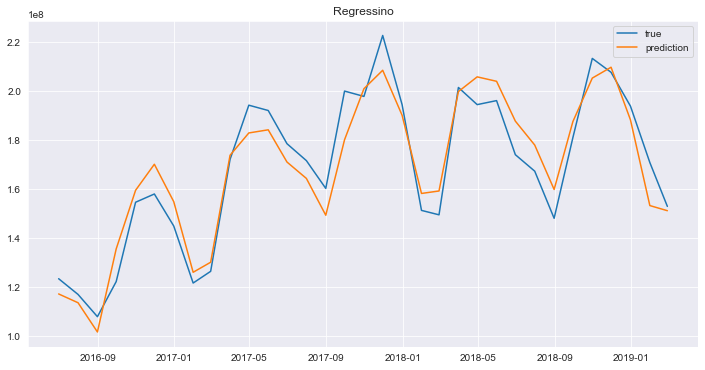

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(buss2.index[0:], buss2.values[0:], label = 'true');
ax.plot(buss2.index[0:], fitted_model1.predict(), label='prediction');
ax.legend();
ax.set_title("Regressino");

In [260]:
newnewdadummy3.tail(3)

,const,3,4,5,6,7,9,10,11,12,time,time1
2018-12-31,1.0,0,0,0,0,0,0,0,0,1,31,961
2019-01-31,1.0,0,0,0,0,0,0,0,0,0,32,1024
2019-02-28,1.0,0,0,0,0,0,0,0,0,0,33,1089


In [259]:
buss2.tail()

2018-10-31    2.134454e+08
2018-11-30    2.077768e+08
2018-12-31    1.939720e+08
2019-01-31    1.709335e+08
2019-02-28    1.530403e+08
Freq: M, dtype: float64

In [261]:
resultbuss2 = [188799600,191717500]

# 시계열 회귀모형을 이용한 BUSS2 의 최종 2달 예측값은 이렇다.

# =========================================================
# 경계선
#  =========================================================

## 이것이 최종모형들로 구한 2달의 예측값들 

In [285]:
resultholt = [195068600, 210152600]
resultarima = [163898977, 180719405]
resultregre = [188799600, 191717500]

In [286]:
result1month = (resultholt[0] + resultarima[0] + resultregre[0])/3
result2month = (resultholt[1] + resultarima[1] + resultregre[1])/3

In [287]:
print(result1month)
print(result2month)

182589059.0
194196501.66666666


## 세개의 모형이 각각 계절성, 추세를 반영하는 방식, 비율등이 다른 것을 알고 있다. 그로인해 각각의 장단점을 가져오고자 앙상블(Ensemble) 형식으로 세 기법을 통해 얻은 값들의 평균을 예측치로 사용하려 한다.

# =========================================================
# 경계선
#  =========================================================

In [556]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [560]:
def kpss_test(data):
    statistic, p_value, n_lags, critical_values = kpss(data, regression='c', lags='auto')
    print(f'KPSS test results:')
    print(f'\t\t Test Statistic:  {statistic}')
    print(f'\t\t p-value: {p_value}')


    print("-----------------result----------------------")
    if(p_value <= 0.05):
        print(p_value," <= 0.05 이므로 유의수준 5%하에서 귀무가설을 기각할만한 충분한 근거가 되므로 정상성을 만족한다")
    else:
        print(p_value," > 0.05 이므로 유의수준 5%하에서 귀무가설을 기각하지못한다. 자료에 단위근이 존재한다")

In [604]:
kpss_test(buss2di1)

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'lags' keyword is deprecated, use 'nlags' instead
  
C:\Users\WIN10HOME\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


KPSS test results:
		 Test Statistic:  0.25084691987877505
		 p-value: 0.1
-----------------result----------------------
0.1  > 0.05 이므로 유의수준 5%하에서 귀무가설을 기각하지못한다. 자료에 단위근이 존재한다


In [591]:
kpss_test(buss2)

C:\Users\WIN10HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'lags' keyword is deprecated, use 'nlags' instead
  


KPSS test results:
		 Test Statistic:  0.5461094537339175
		 p-value: 0.03128165456443299
-----------------result----------------------
0.03128165456443299  <= 0.05 이므로 유의수준 5%하에서 귀무가설을 기각할만한 충분한 근거가 되므로 정상성을 만족한다


In [573]:
buss2di1 = buss2.diff()

In [574]:
buss2di1 = buss2di1[1:]

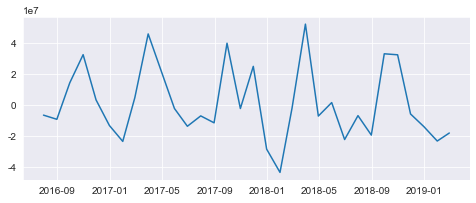

In [577]:
plt.figure(figsize=(8,3))
plt.plot(buss2di1)

## 오히려 차분을 하지않은 buss2가 정상성을 충분히 만족했다.

# -----------------------------------------------------------